# 项目：指导四轴飞行器学会飞行

在此项目中，你将设计一个能够使四轴飞行器飞行的智能体，然后使用你所选的强化学习算法训练它！请尝试运用你在这一单元中学到的知识，看看哪个方法效果最好，当然你也可以自己想出创新型方法并测试它们。

![Quadcopter doing a flip trying to takeoff from the ground](images/quadcopter_tumble.png)

## 说明

> **请注意**：如果你还未开始，请参照本代码库中的 README 文件来安装 ROS，确保模拟器正常运转，并被正确连接至 ROS。

当你准备好编写代码时，请先查看 `quad_controller_rl/src/` （源）目录来更好地了解项目结构。下面是一些重要文件：

- `src/`: 包含本项目的所有源代码。
  - `quad_controller_rl/`: 这是你将使用的 Python 包的 root 文件夹。
  - ...
  - `tasks/`: 在本子目录中定义你的任务（环境）。
    - `__init__.py`: 当你定义一个新任务时，你需要将它导入至本文件中。
    - `base_task.py`: 所有任务的基类，包含文档。
    - `takeoff.py`: 这是第一个任务，我们已经为你定义好，并按默认配置运行。
  - ...
  - `agents/`: 请在这里编写你的强化学习智能体。
    - `__init__.py`: 当你定义新的智能体时，需要将它导入至此处，同任务相似。
    - `base_agent.py`: 所有智能体的基类，包含文档。
    - `policy_search.py`: 我们为你提供了智能体模板，按默认配置运行。
  - ...


### 任务

请打开任务的基类，`BaseTask`，在 `tasks/base_task.py` 中定义。

In [2]:
class BaseTask:
    """Generic base class for reinforcement learning tasks."""

    def __init__(self):
        """Define state and action spaces, initialize other task parameters."""
        pass
    
    def set_agent(self, agent):
        """Set an agent to carry out this task; to be called from update."""
        self.agent = agent
    
    def reset(self):
        """Reset task and return initial condition."""
        raise NotImplementedError
    
    def update(self, timestamp, pose, angular_velocity, linear_acceleration):
        """Process current data, call agent, return action and done flag."""
        raise NotImplementedError            

要想顺利运行，所有任务都必须从此类中继承。在定义一个任务时，你将需要覆盖 `reset()` 和 `update()` 方法，否则将会出现 `NotImplementedError`'。除了这两个方法外，你还应该为构造器中的任务 `__init__()` 定义状态（观察）空间和行动空间，并初始化其他需要的变量来使任务顺利运行。

现在请将其与第一个具体的任务 `Takeoff` 比较，并在 `tasks/takeoff.py` 中定义：

In [3]:
class Takeoff(BaseTask):
    """Simple task where the goal is to lift off the ground and reach a target height."""
    ...

在 `__init__()` 中，请注意状态空间和行动空间是使用 [OpenAI Gym spaces](https://gym.openai.com/docs/#spaces) 定义的，与 [`Box`](https://github.com/openai/gym/blob/master/gym/spaces/box.py) 相似。这些对象为智能体提供了简洁有力的界面进行探索。比如，它们可以检查空间的维度（`shape`），并询问界限（`high` and `low`），甚至可以在智能体与环境交互前使用 `sample()` 方法来抽取大量观察值。我们同样为每一个阶段设置了时限（`max_duration`），以及四轴飞行器顺利起飞所需的高度（`target_z`）。

`reset()` 方法旨在让你重置/初始化变量，来为下一个阶段做准备。你并不需要自行调用它，它将被从外部调用。在每一个任务前，它都将被调用，包括第一个任务。`Takeoff` 中并没有任何可初始化的变量，但它必须为任务返回一个有效的_初始状态_，也即一个由 [`Pose`](http://docs.ros.org/api/geometry_msgs/html/msg/Pose.html) 和 [`Twist`](http://docs.ros.org/api/geometry_msgs/html/msg/Twist.html) 组成的元组对象。这些都是 ROS 信息类型，在任务开端，你可以向四轴飞行器传送这些动作（位置和方向）和速度（长度和角度）信息。在每个任务中，你也许会选择同样的初始值，也可能会做出一些改变，比如在 `Takeoff` 中使四轴飞行器的高度随意下降一些。

> **小贴士**： 随意改变一些初始状态可以帮助智能体更快地探索状态空间。

最后，`update()` 方法极为重要。你将使用这种方法来定义任务的动态并传达给智能体。它由一个 ROS 程序进行周期性调用（默认值为每秒 30 次），并与模拟中的当前数据一起。我们还有一系列可供使用的其他参数：`timestamp`（你可以使用这个参数来检查是否超时，或是计算速度），`pose`（四轴飞行器的位置和方向），`angular_velocity`, 和 `linear_acceleration`。你不需要在每个任务中都使用这些参数，比如 `Takeoff` 只需要用到位置信息，而这是一个包含七个元素的状态向量。

一旦你准备好将状态传递给智能体，你将需要计算奖励值，并检查该阶段是否完成（比如智能体超过了时限，或是达到了特定高度）。请注意它们（`reward` 和 `done`）都基于智能体在过去做出的动作。当你编写专属于你的智能体时，请特别注意这一点。

现在你可以将 `state`，`reward` 和 `done` 值传递给智能体的 `step()` 方法，智能体将返回一个动作向量，该向量与你所定义的动作空间一致，在本例中为 `Box(6,)`。在检查该动作向量不是空向量，并将它限制在空间限制之内后，你需要将它转换为一条 ROS `Wrench` 信息。该动作向量的前三个元素被解释为 x，y 和 z 方向上的三个力，其余3个元素分别表示要在这些轴周围施加的扭矩。

从 'update()' 方法返回 'Wrench` 对象（如果你不想采取任何行动，请返回 `None`）或者`done`标志（注意，当 `done` 为 `True` 时，`Wrench` 对象将被忽略，此时你可以返回 `None`）。 这将作为控制命令返回到模拟器，并且会影响四轴飞行器的姿态、方向和速度等。当你在下一个时间步中调用 `update()` 方法时，你将能够评估效果。

### 智能体

强化学习智能体以相似的方法进行定义。打开在 `agents/base_agent.py` 中定义的通用智能体类 `BaseAgent`，以及在 `agents/policy_search.py` 中定义的智能体模板 `RandomPolicySearch`。实际上定义智能体的方法更加简单，你只需实现上面讨论过的 `step()` 方法即可。它需要消耗 `state`（向量），`reward`（标量值）和 `done` （boolean），并创建一个 `action`（向量）。这些状态向量和动作向量都必须与任务中表明的空间对应。就这么简单！

这些都只是为了顺利进行项目。我们提供的智能体模板 `RandomPolicySearch` 使用了非常简单的线性策略，来直接将动作向量视作状态向量和权重矩阵的点积进行计算。接着，它通过添加一些高斯噪声来随机干扰参数，以产生不同的策略。根据每个阶段获得的平均奖励值（“分数“），它将记录迄今为止发现的最佳参数集以及分数的变化状态，并据此调整比例因子来扩大或减少噪音。

In [4]:
%%html
<div style="width: 100%; text-align: center;">
    <h3>Teach a Quadcopter How to Tumble</h3>
    <video poster="images/quadcopter_tumble.png" width="640" controls muted>
        <source src="images/quadcopter_tumble.mp4" type="video/mp4" />
        <p>Video: Quadcopter tumbling, trying to get off the ground</p>
    </video>
</div>

<div style="width: 100%; text-align: center;">
    <h3>Teach a Quadcopter How to Tumble</h3>
    <video poster="images/quadcopter_tumble.png" width="640" controls muted>
        <source src="images/quadcopter_tumble.mp4" type="video/mp4" />
        <p>Video: Quadcopter tumbling, trying to get off the ground</p>
    </video>
</div>


很显然，这个智能体在本次任务中的性能十分糟糕。它的确成功移动了四轴飞行器，这还算不错，但它的起飞并不平稳，常常导致不必要的翻滚和歪斜。这时轮到你出场了，你的第一个_任务_是为本次起飞任务设计一个更加优秀的智能体。你无需修改智能体模板，可以在 `agents/` 目录下创建新的文件，比如 `policy_gradients.py`，并在此定义你自己的智能体。请记住你的智能体必须继承自智能体基类，例如：

In [5]:

class DDPG(BaseAgent):
    ...

NameError: name 'BaseAgent' is not defined

你可以从智能体模板中借鉴你所需要的任何元素，包括如何模块化你的代码（使用 `act()`，`learn()` 和 `reset_episode_vars()` 等辅助方法）。

> **请注意**：该配置看上去与常见的 OpenAI Gym 范例类似，但其中有一个重要区别。此处并非由智能体在环境中调用方法（来执行动作并获取最终状态、奖励和完成值），而是由任务调用方法并传递给智能体（`step()`）。如果你打算存储经验元组进行学习，你将需要缓存最后一个状态 ($S_{t-1}$) 和最后一个动作 ($A_{t-1}$)。接着在下一个时间步中，当你获得新的状态 ($S_t$) 和奖励 ($R_t$)，你可以将它们和 `done` 标志一同储存($\left\langle S_{t-1}, A_{t-1}, R_t, S_t, \mathrm{done?}\right\rangle$)。

当一个阶段结束时，智能体将接收到对 `step()` 方法的最后一次调用，此时 `done` 被设置成 `True`。这时你可以进行任何清除/重置/批量学习（请注意，重置方法无法从智能体外部调用）。返回至此调用的动作将被忽略，因此你可以安全地返回 `None`。下一次调用将是新阶段的开始。

最后，为了运行你的智能体，你将需要编辑 `agents/__init__.py`，并导入你的智能体类，如：

In [6]:
from quad_controller_rl.agents.policy_gradients import DDPG

ModuleNotFoundError: No module named 'quad_controller_rl.agents'

接着，在启动 ROS 时，你将需要在命令行/终端中指定类名：

In [7]:
%%bash
roslaunch quad_controller_rl rl_controller.launch agent:=DDPG

bash: line 1: roslaunch: command not found


好了，现在我们已经完成了第一个任务。请按照下面的说明来实现你的智能体，让它学习如何从地面起飞。对于其他几个任务，你需要定义任务和智能体！请将 `Takeoff` 任务作为指导，并参考 `BaseTask` 文档来获取你需要覆盖的不同方法。你可以使用一些调试打印语句来更好地理解控制流。与建立新的智能体相似，新任务也必须继承自 `BaseTask`，并将它们导入至 `tasks/__init__.py`，在运行时，请在命令行中说明：

In [8]:
%%bash
roslaunch quad_controller_rl rl_controller.launch task:=Hover agent:=DDPG

bash: line 1: roslaunch: command not found


通常，你需要先启动 ROS，接着手动运行模拟器。你也可以使这一流程自动化进行，你可以将模拟器复制/符号化到 `quad_controller_rl/sim/DroneSim`（`DroneSim` 必须是一个可执行文件），也可以在命令行中指定：
> 
> ```bash
> roslaunch quad_controller_rl rl_controller.launch task:=Hover agent:=DDPG sim:=<full path>
> ```

## 任务一：起飞

### 实现起飞的智能体

请训练一个智能体，让它顺利从地面起飞，并抵达特定高度。请在上面描述的 `agents/` 下的文件中开发你的智能体，并至少实现 `step()` 方法，或其他必须的辅助方法。你也许会使用一些强化学习算法（请注意，行动空间由连续变量组成，这也许会限制你的选择）。

我们早已为你定义好该任务（在 `tasks/takeoff.py` 中），请勿编辑此文件。默认目标高度（Z 轴值）为地面以上 10 个单元。并且奖励函数为与设定点之间的负绝对距离（到某个阈值）。当四轴飞行器抵达目标高度（x 值和 y 值、方向、速度等将被忽略）或超过最大持续时间（5 秒）时，该阶段将结束。请查看 `Takeoff.update()` 获取更多细节信息，包括阶段奖励/惩罚。

在开发智能体时，你也需要关注它的性能。请建立机制以在文件中记录/存储智能体在每个阶段中获得的所有奖励。当你对智能体的性能感到满意时，请返回本 notebook，绘制阶段奖励信息，并回答下面的问题。

### 绘制阶段奖励

请绘制智能体在每个阶段中获得的总奖励，这可以是单次运行的奖励值，也可以是多次运行的平均值。

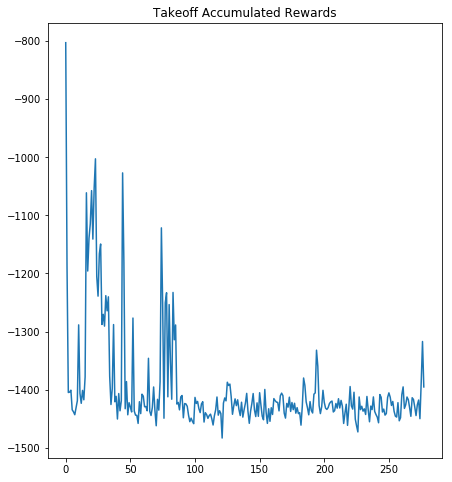

In [9]:
# TODO: Read and plot episode rewards
# 导入episode rewards 数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from IPython.display import display # 允许为DataFrame使用display()


# 为notebook提供更加漂亮的可视化
%matplotlib inline

# 导入 Takeoff 数据
data_takeoff = pd.read_csv("stats_2018-12-05_19-20-28.csv")
data = data_takeoff
# 成功 - 显示第一条记录
#display(data.head(n=1))
episode = data['episode']
reward = data['total_reward']

def plot_results(data, title):
    plt.figure(figsize=(24,8))
    plt.subplot(132)
    plt.title(title + " Accumulated Rewards")
    plt.plot(np.array(reward))
    plt.show()
     
plot_results(data_takeoff, "Takeoff")

**Q**: 你使用了什么算法？请简要说明你为什么在这次任务中使用了该算法。


**A**: 使用了 DDPG 算法。


**Q**: 根据你绘制的阶段奖励图，说明智能体在这段时间内的学习状况。

- 学习该任务是简单还是困难？
- 该学习曲线中是否存在循序渐进或急速上升的部分？
- 该智能体的最终性能有多好？（比如最后十个阶段的平均奖励值）

**A**: 1，学习该任务比较简单
       2，该学习曲线中存在急速上升
       3，很好, 经过278次 Episode, Loss 由3持续下降接近0.2, Critic 在由8 逐渐升到420左右， reward 在1420。


## 任务 2: 悬停

### 实现悬停的智能体

现在，你的智能体必须顺利起飞，并在指定点悬停（比如地面上方 10 个单元）。与之前一样，你将需要创建一个智能体并实现 `step()` 方法（或其他辅助方法）来应用你的强化学习算法。如果你认为你在前一个任务中实现的智能体性能优秀，也可以在新任务中使用并训练它。但请记得储存之前的模型权重/参数，以便记录结果。

### 状态与奖励

即使你使用了相同的智能体，也需要重新创建任务，此时你可以改变进入的状态表示，或是确定阶段结束的方法（四轴飞行器至少需要悬停几秒）等。在本次悬停任务中，你需要将高度作为状态的一部分（否则智能体无法判断你希望它去哪里）。你也许还需要回顾如何计算奖励。你可以在新的任务文件中进行这些操作，比如 `tasks/hover.py`（请按照上方说明的步骤创建新任务）：

In [10]:
class Hover(BaseTask):
    ...

**Q**: 你是否改变了状态表示或奖励函数？如果改变了，请解释哪种方案更好，以及你为何选择这种方案。若有需要，请附上代码片段。

**A**: 是改变了奖励函数，        
reward = -(self.weight_position * error_position  + self.weight_velocity * error_velocity)
这种方案能够充分考虑 智能体重心位置，错误位置，重心速度，错误速度的因素。

### 实现笔记

**Q**: 请在下方简要评论你的实现，可以参照下面几个问题：

- 你尝试了哪些算法？哪种算法最好？
- 你最终选择了什么超参数（比如 $\alpha$，$\gamma$，$\epsilon$ 等）？
- 你使用了什么神经网络结构（如果有的话）？请说明层数、大小和激活函数等参数。


**A**: 
1，项目中尝试了RandomPolicySearch， Actor-Critic， DDPG算法， 其中DDPG算法最好。
2，最终选择了 gamma 为 0.99， 
3，使用了 Keras CNN , 用了2层隐藏层 全连接层(Dense)，activation 为 'relu'， 最终一层 activation 为 sigmoid。

### 绘制阶段奖励

与之前一样，请绘制阶段奖励，这可以是单次运行的奖励值，也可以是多次运行的平均值。请评价学习行为中出现的变化。

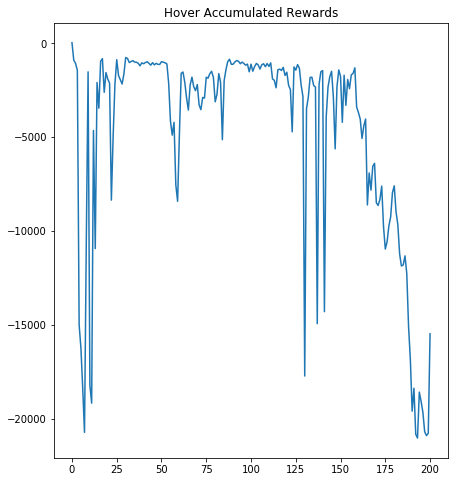

In [11]:
# 导入 Hover 数据
data_hover = pd.read_csv("stats_2018-12-05_18-18-32.csv")
data = data_hover

episode = data['episode']
reward = data['total_reward']
    
plot_results(data_hover, "Hover")

## Task 3: 着陆

起飞的事物终将下落，但安全第一！

### 实现着陆的智能体

这一次，你需要编辑四轴飞行器的初始状态，并将它的位置设置在地面上方（至少 10 个单位）。同时，你将改变奖励函数，让智能体学习_缓慢_降落。同样地，你需要创建一个新的任务（比如 `tasks/landing.py` 中的`Landing`），并实现这些改变。请注意，你需要修改 `reset()` 方法以回到一个空中的位置，可以通过添加上行速度来模仿最近的一次起飞。

在定义任务之后，请新建一个智能体或修改原有的智能体来学习本次任务。你可以借此机会尝试不同的方法和算法。

### 初始条件、状态和奖励

**Q**: 你怎样改变了初始条件（初始状态）、状态表示和/或奖励函数？请解释哪种方案最为合适，以及你为什么选择这种方案。你可以为缓慢着陆构建一个奖励机制吗？


**A**: 
改变了出事状态，weight_position_xy 为 0.5, weight_position_z 为 0.9，target_position 为 [0.0, 0.0, 0.0]， target_velocity 为[0.0, 0.0, -2.0]， weight_velocity 为 0.7。
改变了奖励函数，
        if (state[2] < 8.0):    
            reward = -(self.weight_position_z * error_position_z + self.weight_position_xy * error_position_xy + math.pow(error_velocity, 1.5) * self.weight_velocity )
        else:
            reward = -(self.weight_position_z * error_position_z + self.weight_position_xy * error_position_xy + self.weight_velocity * error_velocity)
目的是当智能体接近落地点 8 units 时，应该缓慢下降着陆。

### 实现笔记

**Q**: 请简要评价你的实现，可以参照上方几个问题。

**A**:充分考虑了智能体着路的要求，对初始状态进行合理设置，并考虑改变奖励函数， 让智能体学习缓慢降落。

### 绘制阶段奖励

与之前一样，请绘制阶段奖励，这可以是单次运行的奖励值，也可以是多次运行的平均值。这个任务同之前不太一样，因为你的智能体从空中开始行动。学习这个任务是否更加困难？为什么？

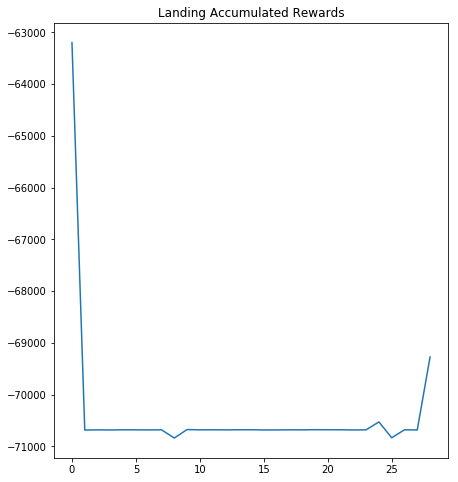

In [12]:
# TODO: Read and plot episode rewards
# 导入 Landing 数据
data_landing = pd.read_csv("stats_2018-12-05_18-07-06.csv")
data = data_landing

episode = data['episode']
reward = data['total_reward']
    
plot_results(data_landing, "Landing")

## Task 4: 整套动作

为了设计一个完整的飞行系统，你需要将这些基础动作融合进一个智能体中。

### 设置端对端任务

我们所考虑的端对端任务只是简单的起飞、在特定点持续悬停和着陆。是时候创建一个新的任务了！但请先思考一下你应该如何着手。这是一个按顺序激活子任务的元任务吗？单独的组合任务——比如路径点——是否更容易实现？在这里并没有正确答案，请通过实验找到最佳方法（并回答以下问题）。

**Q**: 你最终选择了怎样的设置来完成这个组合任务？请简要说明。

**A**:
        max_duration = 7.0  # 持续时长 7secs
        max_error_velocity = 13.0  # 速度13 units
        max_error_position = 5.0  # 距离 units xy
        target_position = np.array([0.0, 0.0, 0.0])  # 目标位置
        weight_position_xy = 0.5 #重心位置
        weight_position_z = 0.9  #重心高度
        target_orientation = np.array([0.0, 0.0, 0.0, 1.0])  # 目标 orientation quaternion (upright)
        weight_orientation = 0.3 #重心 orientation
        target_velocity = np.array([0.0, 0.0, -2.0])  # 目标速度 velocity
        weight_velocity = 0.7 #重心速度

        这样设置，有助于智能体完成从起飞，悬停，着陆等连续动作，有充分的持续时长，合适的上升与下降速度及目标位置等。

### 实现整套动作的智能体

请使用你的端对端任务，实现一个完成整套动作的智能体，让它学习起飞（至少抵达地面以上 10 个单元）、悬停（同样地，至少在地面以上 10 个单元的位置悬停）并缓慢降落。

### 组合方案与实现笔记

就如同任务本身那样，你可以自行决定是分开训练三个（子）智能体，还是训练一个智能体来完成这个端对端任务。

**Q**: 你最终达到了怎样的结果？是否遇到了挑战？又怎样解决了这些挑战？请在评价你的实现。


**A**: 通过训练一个智能体来完成这个端对端任务，通过一个 Combine 任务，对智能体不同阶段设置不同的状态及奖励函数，通过 step 函数，完成reward及状态 学习及更新。

### 绘制阶段奖励

与之前一样，请绘制阶段奖励，这可以是单次运行的奖励值，也可以是多次运行的平均值。

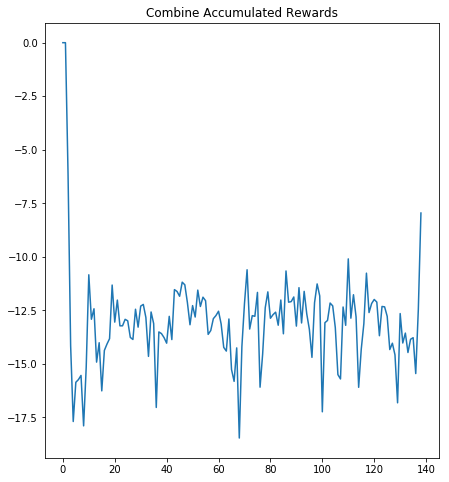

In [13]:
# TODO: Read and plot episode rewards
# 导入 Landing 数据
data_combine = pd.read_csv("stats_2018-12-05_18-31-28.csv")
data = data_combine

episode = data['episode']
reward = data['avg_reward']
    
plot_results(data_combine, "Combine")

## 回顾

**Q**: 请简要总结你的本次项目经历。你可以参考以下问题：

- 本次项目中最困难的部分是什么？（例如开始项目、运行 ROS、绘制、特定的任务等。）
- 你如何完成每个任务？又如何为它选择合适的算法/实现？
- 关于四轴飞行器和你的智能体的行为，你是否有一些有趣的发现？

**A**:
本项目最困难的部分是 运行ROS 及完成Hover 任务。
对任务先单个训练智能体，设置合适的参数及奖励函数，选择合适的算法； 由于每个任务是Reinforcement Learning 要解决的问题：让agent学习在一个环境中的如何行为动作(act)， 从而获得最大的奖励值总和(total reward)，这个奖励值一般与agent定义的任务目标关联。由于这套飞行任务又是连续性的，需要连续行为的策略学习，因此我们选择使用DDPG算法来完成。
关于四轴飞行器和智能体的行为，我发现即使智能体在起飞，悬浮，着陆过程中有摇摆行为，但给到的奖励仍然比较高，也就是说奖励无法很全面的评价智能体在全过程中是否稳定运行。

### 我准备好了！
当你准备好提交项目时，请点击页面底部的**提交项目**按钮。

如果你在提交项目时遇到任何问题，或是想确认你的提交状态，请向我们发送电子邮件 (**support@youdaxue.com**) 或访问我们的<a href="https://discussions.youdaxue.com" target="_blank">论坛</a>。

### 接下来会发生什么？
审阅专家会将反馈发送到你的电子邮箱。在此期间，请继续学习后面的项目和内容！